## Patient Readmission Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# load the csv file
data_frame = pd.read_csv('diabetic_data.csv')

In [3]:
print('Number of samples: ', len(data_frame))

Number of samples:  101766


Overview of the dataset

In [4]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [5]:
data_frame.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


The most important column here is 'readmitted'. This describes if the patient was readmitted withing 30 days, after 30 days or no readmitted. 

In [6]:
data_frame.groupby('readmitted').size()

readmitted
<30    11357
>30    35545
NO     54864
dtype: int64

Another column that is important is 'discharge_disposition_id', which tells us where the patient went after the hospitalization. 

In [7]:
data_frame.groupby('discharge_disposition_id').size()

discharge_disposition_id
1     60234
2      2128
3     13954
4       815
5      1184
6     12902
7       623
8       108
9        21
10        6
11     1642
12        3
13      399
14      372
15       63
16       11
17       14
18     3691
19        8
20        2
22     1993
23      412
24       48
25      989
27        5
28      139
dtype: int64

Mapping the valeus of 'discharge_disposition_id' in IDs_mapping.csv, we can see that 11,13,14,19,20,21 are related to death or hospice. Hence, we need to remove these samples from the predictive model.

In [8]:
data_frame = data_frame.loc[~data_frame.discharge_disposition_id.isin([11,13,14,19,20,21])]

Define an output variable for our binary classification. This will help us predict if a patient is likely to be re-admitted within 30 days of discharge: OUTPUT_LABEL

In [9]:
data_frame['readmitted'].unique()

array(['NO', '>30', '<30'], dtype=object)

In [10]:
df = data_frame.copy()

In [11]:
df['OUTPUT_LABEL'] = (df.readmitted == '<30').astype('int')
#Assigns 1 if readmitted is '<30' and 0 otherwise

Defining a function to calculate the percentage (prevalence) of people who were readmitted within 30 days.

In [12]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

In [13]:
#print('Prevalence:%.3f'%calc_prevalence(df['OUTPUT_LABEL'].values))
print('Prevalence: %.3f' % calc_prevalence(df['OUTPUT_LABEL'].values))

Prevalence: 0.114


Hence, this shows that 11.4% of the population was readmitted. 
This represented an imbalanced classification problem so we will address that now.

In [14]:
df[list(df.columns)[:10]].head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1


In [15]:
df[list(df.columns)[10:20]].head()

,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2
0,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?
1,?,?,59,0,18,0,0,0,276,250.01
2,?,?,11,5,13,2,0,1,648,250
3,?,?,44,1,16,0,0,0,8,250.43
4,?,?,51,0,8,0,0,0,197,157


In [16]:
df[list(df.columns)[20:30]].head()

,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide
0,?,1,None,None,No,No,No,No,No,No
1,255,9,None,None,No,No,No,No,No,No
2,V27,6,None,None,No,No,No,No,No,No
3,403,7,None,None,No,No,No,No,No,No
4,250,5,None,None,No,No,No,No,No,No


In [17]:
df[list(df.columns)[30:40]].head()

,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide
0,No,No,No,No,No,No,No,No,No,No
1,No,No,No,No,No,No,No,No,No,No
2,Steady,No,No,No,No,No,No,No,No,No
3,No,No,No,No,No,No,No,No,No,No
4,Steady,No,No,No,No,No,No,No,No,No


In [18]:
df[list(df.columns)[40:]].head()

,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,OUTPUT_LABEL
0,No,No,No,No,No,No,No,No,No,NO,0
1,No,Up,No,No,No,No,No,Ch,Yes,>30,0
2,No,No,No,No,No,No,No,No,Yes,NO,0
3,No,Up,No,No,No,No,No,Ch,Yes,NO,0
4,No,Steady,No,No,No,No,No,Ch,Yes,NO,0


There are a lot of categorical (non-numeric) variables. So let's take a look at the unique values for each column.

In [19]:
# for each column
for c in list(df.columns):
    
    # get a list of unique values
    n = df[c].unique()
    
    # if number of unique values is less than 30, print the values. Otherwise print the number of unique values
    if len(n)<30:
        print(c)
        print(n)
    else:
        print(c + ': ' +str(len(n)) + ' unique values')

encounter_id: 99343 unique values
patient_nbr: 69990 unique values
race
['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
gender
['Female' 'Male' 'Unknown/Invalid']
age
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
weight
['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
admission_type_id
[6 1 2 3 4 5 8 7]
discharge_disposition_id
[25  1  3  6  2  5  7 10  4 18  8 12 16 17 22 23  9 15 24 28 27]
admission_source_id
[ 1  7  2  4  5 20  6  3 17  8  9 14 10 22 11 25 13]
time_in_hospital
[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
payer_code
['?' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
medical_specialty: 73 unique values
num_lab_procedures: 118 unique values
num_procedures
[0 5 1 6 2 3 4]
num_medications: 75 unique values
number_outpatient: 39 unique values
number_emergency: 33 unique values
number_inpatient
[ 0  1  2  3  6 

On analysing these values, we observe that:
- encounter_id and patient_nbr: these are just identifiers and not useful variables
- examide and citoglipton only have 1 value, so we will not use these variables
- diag1, diag2, diag3 - are categorical and have a lot of values. We will not use these as part of this project, but you could group these ICD codes to reduce the dimension. We will use number_diagnoses to capture some of this information.
- age and weight: are categorical in this data set
- admission_type_id, discharge_disposition_id, admission_source_id: are numerical here, but are IDs (as per IDs_mapping). So they should be considered categorical. 
- medical_speciality - has many categorical variables, so we should consider this when making features. 

## Feature Engineering

The dataset comprises of many missing values denoted by '?'. So we will replace it by NaN.

In [20]:
df = df.replace('?', np.nan)

### Numerical Features

In [21]:
cols_num = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']

In [22]:
df[cols_num].isnull().sum()
# To check if these columns have any missing values

time_in_hospital      0
num_lab_procedures    0
num_procedures        0
num_medications       0
number_outpatient     0
number_emergency      0
number_inpatient      0
number_diagnoses      0
dtype: int64

### Categorical Features

In [23]:
cols_cat = ['race', 'gender', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed','payer_code']

In [24]:
df[cols_cat].isnull().sum()
# To check if these columns have any missing values

race                         2234
gender                          0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
tolazamide                      0
insulin                         0
glyburide-metformin             0
glipizide-metformin             0
glimepiride-pioglitazone        0
metformin-rosiglitazone         0
metformin-pioglitazone          0
change                          0
diabetesMed                     0
payer_code                  39398
dtype: int64

race, payer_code, and medical_specialty have missing data. Since these are categorical data, the best thing to do is to just add another categorical type for unknown using the fillna function.

In [25]:
df['race'] = df['race'].fillna('UNK')
df['payer_code'] = df['payer_code'].fillna('UNK')
df['medical_specialty'] = df['medical_specialty'].fillna('UNK')

In [26]:
print('Number medical specialty:', df.medical_specialty.nunique())
df.groupby('medical_specialty').size().sort_values(ascending = False)

Number medical specialty: 73


medical_specialty
UNK                                 48616
InternalMedicine                    14237
Emergency/Trauma                     7419
Family/GeneralPractice               7252
Cardiology                           5279
                                    ...  
Surgery-PlasticwithinHeadandNeck        1
Dermatology                             1
Proctology                              1
Psychiatry-Addictive                    1
Speech                                  1
Length: 73, dtype: int64

We can see that most of them are unknown and that the count drops off pretty quickly. 
We don't want to add 73 new variables since some of them only have a few samples. As an alternative, we can create a new variable that only has 11 options (the top 10 specialities and then an other category).

In [27]:
top_10 = ['UNK','InternalMedicine','Emergency/Trauma',\
          'Family/GeneralPractice', 'Cardiology','Surgery-General' ,\
          'Nephrology','Orthopedics',\
          'Orthopedics-Reconstructive','Radiologist']

# make a new column with duplicated data
df['med_spec'] = df['medical_specialty'].copy()

# replace all specialties not in top 10 with 'Other' category
df.loc[~df.med_spec.isin(top_10),'med_spec'] = 'Other'

In [28]:
df.groupby('med_spec').size()

med_spec
Cardiology                     5279
Emergency/Trauma               7419
Family/GeneralPractice         7252
InternalMedicine              14237
Nephrology                     1539
Orthopedics                    1392
Orthopedics-Reconstructive     1230
Other                          8199
Radiologist                    1121
Surgery-General                3059
UNK                           48616
dtype: int64

To convert these categorical features to numbers, we will use a technique called one-hot encoding. 
To deal with this, we can use the drop_first option, which will drop the first categorical value for each column.

The get_dummies function does not work on numerical data. To trick get_dummies, we can convert the numerical data into strings and then it will work properly.

In [29]:
cols_cat_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
df[cols_cat_num] = df[cols_cat_num].astype('str')

Now, we will create all the categorical features

In [30]:
df_cat = pd.get_dummies(df[cols_cat + cols_cat_num + ['med_spec']],drop_first = True)

In [31]:
df_cat.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK,gender_Male,gender_Unknown/Invalid,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,...,med_spec_Emergency/Trauma,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


Adding the one-hot encoding columns to the dataframe.

In [32]:
df = pd.concat([df,df_cat], axis = 1)

In [33]:
cols_all_cat = list(df_cat.columns)

### Extra features

For the columns 'age' and 'weight', these should ideally be numerical. But in this case, 
- 'age' has categorical values and so we convert them into numerical values.
- 'weight' has empty and null values, so we 

In [34]:
df.groupby('age').size()

age
[0-10)        160
[10-20)       690
[20-30)      1649
[30-40)      3764
[40-50)      9607
[50-60)     17060
[60-70)     22059
[70-80)     25331
[80-90)     16434
[90-100)     2589
dtype: int64

Let's map these to 0-9 for the numerical data.

In [35]:
age_id = {'[0-10)':0, 
          '[10-20)':10, 
          '[20-30)':20, 
          '[30-40)':30, 
          '[40-50)':40, 
          '[50-60)':50,
          '[60-70)':60, 
          '[70-80)':70, 
          '[80-90)':80, 
          '[90-100)':90}
df['age_group'] = df.age.replace(age_id)
df.weight.notnull().sum()

3125

Now we create a variable to say if weight was filled out or not. The presence of a variable might be predictive regardless of the value.

In [36]:
df['has_weight'] = df.weight.notnull().astype('int')

In [37]:
cols_extra = ['age_group','has_weight']

### Engineering Features Summary

In [38]:
print('Total number of features:', len(cols_num + cols_all_cat + cols_extra))
print('Numerical Features:',len(cols_num))
print('Categorical Features:',len(cols_all_cat))
print('Extra features:',len(cols_extra))

Total number of features: 143
Numerical Features: 8
Categorical Features: 133
Extra features: 2


In [39]:
df[cols_num + cols_all_cat + cols_extra].isnull().sum().sort_values(ascending = False).head(10)
#Checking if we are missing any data

time_in_hospital               0
discharge_disposition_id_16    0
admission_type_id_6            0
admission_type_id_7            0
admission_type_id_8            0
discharge_disposition_id_10    0
discharge_disposition_id_12    0
discharge_disposition_id_15    0
discharge_disposition_id_17    0
admission_type_id_4            0
dtype: int64

Creating a dataframe that has only necessary columns

In [40]:
new_df = cols_num + cols_all_cat + cols_extra
df_data = df[new_df + ['OUTPUT_LABEL']]

Now that we have explored our data and created features from the categorical data, we will split our data to measure how well the model would work

### Building Training/Validation/Test Samples 

We split our data into three parts: 
- Training samples: these samples are used to train the model 
- Validation samples: these samples are held out from the training data and are used to make decisions on how to improve the model 
- Test samples: these samples are held out from all decisions and are used to measure the generalized performance of the model

In this project, we will split into 70% train, 15% validation, 15% test.

First we'll shuffle the samples, in case there was an order. 

In [41]:
df_data = df_data.sample(n = len(df_data), random_state = 42)
df_data = df_data.reset_index(drop = True)
# random_state is just specified so the entire class gets the same shuffling. 

Extract 30% for Validation & Test

In [42]:
df_valid_test = df_data.sample(frac=0.30, random_state=42)
print('Split size: %.3f' % (len(df_valid_test) / len(df_data)))

Split size: 0.300


Split Validation & Test (15% each)

In [43]:
df_test = df_valid_test.sample(frac=0.5, random_state=42)
df_valid = df_valid_test.drop(df_test.index)

In [44]:
# use the rest of the data as training data
df_train_all=df_data.drop(df_valid_test.index)

Let's check what percent of our groups are hospitalized within 30 days.

In [45]:
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prevalence(df_test.OUTPUT_LABEL.values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prevalence(df_valid.OUTPUT_LABEL.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prevalence(df_train_all.OUTPUT_LABEL.values)))

Test prevalence(n = 14902):0.117
Valid prevalence(n = 14901):0.113
Train all prevalence(n = 69540):0.113


In [46]:
print('all samples (n = %d)'%len(df_data))
assert len(df_data) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'
#Verifying that we used all the data.

all samples (n = 99343)


In [47]:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.OUTPUT_LABEL.values)))

Train balanced prevalence(n = 15766):0.500


In [48]:
#Saving data
df_train_all.to_csv('df_train_all.csv',index=False)
df_train.to_csv('df_train.csv',index=False)
df_valid.to_csv('df_valid.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

In [49]:
X_train = df_train[new_df].values
X_train_all = df_train_all[new_df].values
X_valid = df_valid[new_df].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (69540, 143)
Training shapes: (15766, 143) (15766,)
Validation shapes: (14901, 143) (14901,)


Scaling data:

In [50]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train_all)

StandardScaler()

We will need this scaler for the test data, so let's save it using a package called pickle.

In [51]:
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [52]:
# load it back
scaler = pickle.load(open(scalerfile, 'rb'))

In [53]:
# transforming our data matrices

X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

### Model Selection

We train a few machine learning models and use a few techniques for optimizing them. We will then select the best model based on performance on the validation set.

In [54]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 

In [55]:
thresh = 0.5

We will compare the performance of 7 machine learning models using default hyperparameters.

#### K-Nearest Neighbors

In [56]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

KNN
Training:
AUC:0.650
accuracy:0.603
recall:0.491
precision:0.633
specificity:0.673
prevalence:0.500
 
Validation:
AUC:0.621
accuracy:0.670
recall:0.469
precision:0.165
specificity:0.655
prevalence:0.113
 


#### Logistic Regression 

In [57]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 42)
lr.fit(X_train_tf, y_train)

y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.678
accuracy:0.628
recall:0.558
precision:0.649
specificity:0.698
prevalence:0.500
 
Validation:
AUC:0.661
accuracy:0.662
recall:0.558
precision:0.180
specificity:0.675
prevalence:0.113
 


#### Stochastic Gradient Descent

In [58]:
from sklearn.linear_model import SGDClassifier
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train_tf, y_train)

y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

print('Stochastic Gradient Descend')
print('Training:')
sgdc_train_auc, sgdc_train_accuracy, sgdc_train_recall, sgdc_train_precision, sgdc_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, sgdc_valid_precision, sgdc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Stochastic Gradient Descend
Training:
AUC:0.676
accuracy:0.624
recall:0.550
precision:0.645
specificity:0.698
prevalence:0.500
 
Validation:
AUC:0.661
accuracy:0.664
recall:0.553
precision:0.180
specificity:0.678
prevalence:0.113
 


#### Naive Boyes

In [59]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_tf, y_train)

y_train_preds = nb.predict_proba(X_train_tf)[:,1]
y_valid_preds = nb.predict_proba(X_valid_tf)[:,1]

print('Naive Bayes')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Naive Bayes
Training:
AUC:0.508
accuracy:0.506
recall:0.989
precision:0.503
specificity:0.022
prevalence:0.500
 
Validation:
AUC:0.505
accuracy:0.129
recall:0.988
precision:0.114
specificity:0.020
prevalence:0.113
 


#### Decision Tree Classifier 

In [60]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train_tf, y_train)

y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Decision Tree
Training:
AUC:0.736
accuracy:0.672
recall:0.629
precision:0.688
specificity:0.713
prevalence:0.500
 
Validation:
AUC:0.623
accuracy:0.636
recall:0.570
precision:0.170
specificity:0.642
prevalence:0.113
 


#### Random Forest

In [61]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.696
accuracy:0.643
recall:0.612
precision:0.652
specificity:0.673
prevalence:0.500
 
Validation:
AUC:0.657
accuracy:0.629
recall:0.604
precision:0.173
specificity:0.633
prevalence:0.113
 


#### Gradient Boosting Classifier

In [62]:
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Gradient Boosting Classifier
Training:
AUC:0.772
accuracy:0.695
recall:0.668
precision:0.706
specificity:0.722
prevalence:0.500
 
Validation:
AUC:0.639
accuracy:0.620
recall:0.574
precision:0.164
specificity:0.626
prevalence:0.113
 


### Analyze results baseline models

Creating a dataframe with these results and plot the outcomes using seaborn. 
We will utilize the Area under the ROC curve (AUC) to evaluate the best model. 

In [63]:
df_results = pd.DataFrame({'classifier':['KNN','KNN','LR','LR','SGD','SGD','NB','NB','DT','DT','RF','RF','GB','GB'],
                           'data_set':['train','valid']*7,
                          'auc':[knn_train_auc, knn_valid_auc,lr_train_auc,lr_valid_auc,sgdc_train_auc,sgdc_valid_auc,nb_train_auc,nb_valid_auc,tree_train_auc,tree_valid_auc,rf_train_auc,rf_valid_auc,gbc_valid_auc,gbc_valid_auc,],
                          'accuracy':[knn_train_accuracy, knn_valid_accuracy,lr_train_accuracy,lr_valid_accuracy,sgdc_train_accuracy,sgdc_valid_accuracy,nb_train_accuracy,nb_valid_accuracy,tree_train_accuracy,tree_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,gbc_valid_accuracy,gbc_valid_accuracy,],
                          'recall':[knn_train_recall, knn_valid_recall,lr_train_recall,lr_valid_recall,sgdc_train_recall,sgdc_valid_recall,nb_train_recall,nb_valid_recall,tree_train_recall,tree_valid_recall,rf_train_recall,rf_valid_recall,gbc_valid_recall,gbc_valid_recall,],
                          'precision':[knn_train_precision, knn_valid_precision,lr_train_precision,lr_valid_precision,sgdc_train_precision,sgdc_valid_precision,nb_train_precision,nb_valid_precision,tree_train_precision,tree_valid_precision,rf_train_precision,rf_valid_precision,gbc_valid_auc,gbc_valid_precision,],
                          'specificity':[knn_train_specificity, knn_valid_specificity,lr_train_specificity,lr_valid_specificity,sgdc_train_specificity,sgdc_valid_specificity,nb_train_specificity,nb_valid_specificity,tree_train_specificity,tree_valid_specificity,rf_train_specificity,rf_valid_specificity,gbc_valid_specificity,gbc_valid_specificity,]})

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

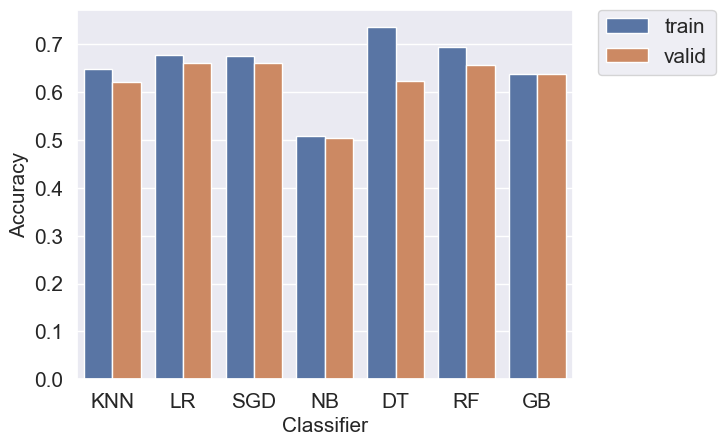

In [67]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('Accuracy', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

### Model Selection: Learning Curve

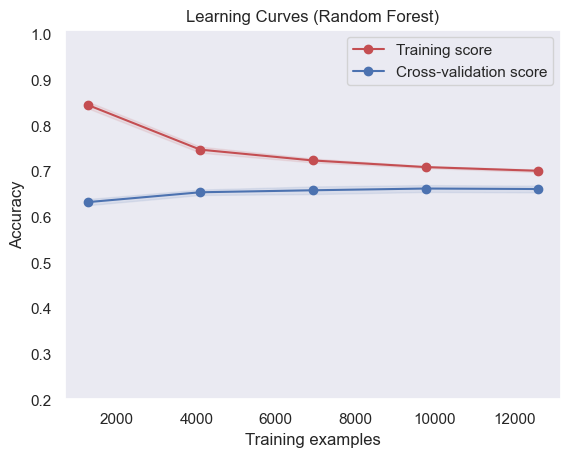

In [68]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves (Random Forest)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = RandomForestClassifier(max_depth = 6, random_state = 42)
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

In the case of random forest, we can see the training and validation scores are similar but they both have low scores. This is called high bias and is a sign of underfitting.



### Model Selection: Feature Importance

In [71]:
feature_importances = pd.DataFrame(lr.coef_[0],
                                   index = new_df,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head()

,importance
number_inpatient,0.356971
rosiglitazone_No,0.284600
rosiglitazone_Steady,0.238721
discharge_disposition_id_22,0.202499
repaglinide_No,0.169205


#### Positive and Negative Feature Importance Score - Logistic Regression

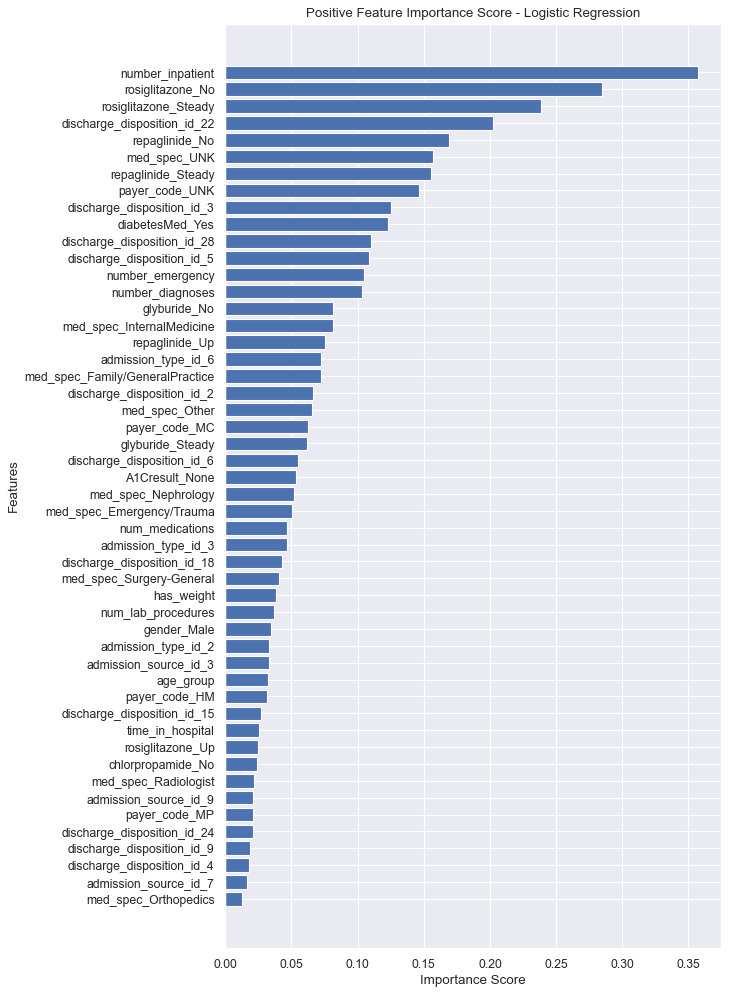

In [72]:
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

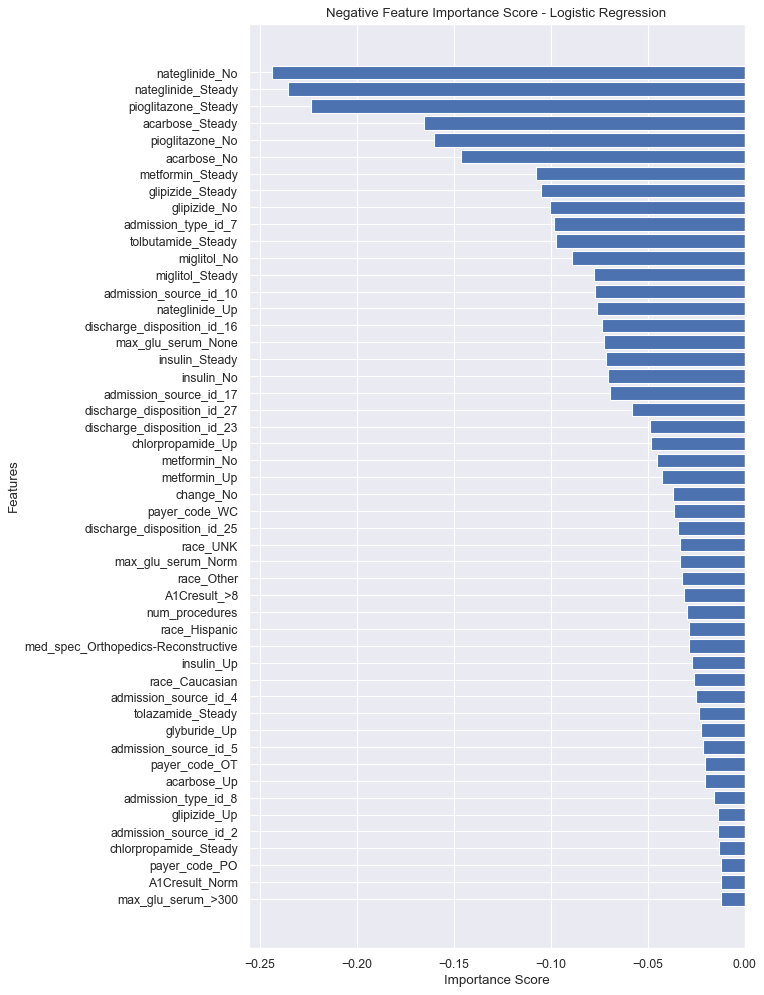

In [73]:
values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()


#### Feature Importance: Random Forest

In [74]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = new_df,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head()


,importance
number_inpatient,0.280585
number_emergency,0.076902
discharge_disposition_id_22,0.070238
num_medications,0.060644
number_diagnoses,0.049529


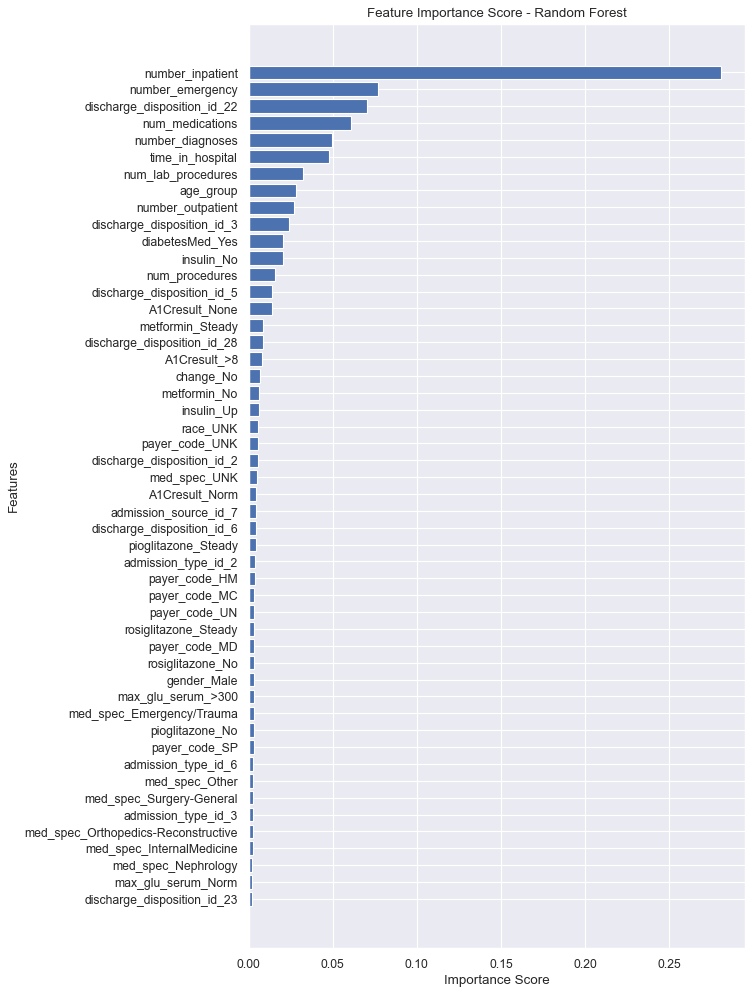

In [75]:
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()

### Model Selection: Hyperparameter Tuning

In this section, we will only optimize the hyper parameters for stochastic gradient descent, random forest and gradient boosting classifier.

In [77]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [81]:
# Creating a grid where we can test all possible combinations over a grid of values 
from sklearn.model_selection import RandomizedSearchCV

# number of trees
n_estimators = range(200,1000,200)
# maximum number of features to use at each split
max_features = ['auto','sqrt']
# maximum depth of the tree
max_depth = range(1,10,1)
# minimum number of samples to split a node
min_samples_split = range(2,10,2)
# criterion for evaluating a split
criterion = ['gini','entropy']

# random grid

random_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'criterion':criterion}

print(random_grid)

{'n_estimators': range(200, 1000, 200), 'max_features': ['auto', 'sqrt'], 'max_depth': range(1, 10), 'min_samples_split': range(2, 10, 2), 'criterion': ['gini', 'entropy']}


In [82]:
from sklearn.metrics import make_scorer, roc_auc_score
auc_scoring = make_scorer(roc_auc_score)

In [83]:
# create the randomized search cross-validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 20, cv = 2, scoring=auc_scoring,
                               verbose = 1, random_state = 42)

In [84]:
# fit the random search model (this will take a few minutes)
t1 = time.time()
rf_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
90.53545880317688


In [85]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 8,
 'max_features': 'auto',
 'max_depth': 8,
 'criterion': 'entropy'}

Analyzing the performance of the best model compared to the baseline model.

In [86]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Baseline Random Forest')
rf_train_auc_base = roc_auc_score(y_train, y_train_preds)
rf_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(rf_train_auc_base))
print('Validation AUC:%.3f'%(rf_valid_auc_base))

print('Optimized Random Forest')
y_train_preds_random = rf_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = rf_random.best_estimator_.predict_proba(X_valid_tf)[:,1]

rf_train_auc = roc_auc_score(y_train, y_train_preds_random)
rf_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(rf_train_auc))
print('Validation AUC:%.3f'%(rf_valid_auc))

Baseline Random Forest
Training AUC:0.696
Validation AUC:0.657
Optimized Random Forest
Training AUC:0.717
Validation AUC:0.660


In [87]:
penalty = ['none','l2','l1']
max_iter = range(100,500,100)
alpha = [0.001,0.003,0.01,0.03,0.1,0.3]
random_grid_sgdc = {'penalty':penalty,
              'max_iter':max_iter,
              'alpha':alpha}
# create the randomized search cross-validation
sgdc_random = RandomizedSearchCV(estimator = sgdc, param_distributions = random_grid_sgdc, 
                                 n_iter = 20, cv = 2, scoring=auc_scoring,verbose = 0, 
                                 random_state = 42)

t1 = time.time()
sgdc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

C:\Users\Tamanna Kapoor\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Tamanna Kapoor\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Tamanna Kapoor\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Tamanna Kapoor\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Tamanna Kapoor\

9.623019933700562


In [89]:
sgdc_random.best_params_

{'penalty': 'l2', 'max_iter': 100, 'alpha': 0.1}

In [90]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

print('Baseline sgdc')
sgdc_train_auc_base = roc_auc_score(y_train, y_train_preds)
sgdc_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(sgdc_train_auc_base))
print('Validation AUC:%.3f'%(sgdc_valid_auc_base))
print('Optimized sgdc')
y_train_preds_random = sgdc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = sgdc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
sgdc_train_auc = roc_auc_score(y_train, y_train_preds_random)
sgdc_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(sgdc_train_auc))
print('Validation AUC:%.3f'%(sgdc_valid_auc))

Baseline sgdc
Training AUC:0.676
Validation AUC:0.661
Optimized sgdc
Training AUC:0.676
Validation AUC:0.661


In [91]:
# number of trees
n_estimators = range(100,500,100)

# maximum depth of the tree
max_depth = range(1,5,1)

# learning rate
learning_rate = [0.001,0.01,0.1]

# random grid

random_grid_gbc = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'learning_rate':learning_rate}

# create the randomized search cross-validation
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid_gbc,
                                n_iter = 20, cv = 2, scoring=auc_scoring,
                                verbose = 0, random_state = 42)

t1 = time.time()
gbc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

194.44043135643005


In [92]:
gbc_random.best_params_

{'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}

In [93]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Baseline gbc')
gbc_train_auc_base = roc_auc_score(y_train, y_train_preds)
gbc_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(gbc_train_auc_base))
print('Validation AUC:%.3f'%(gbc_valid_auc_base))

print('Optimized gbc')
y_train_preds_random = gbc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = gbc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
gbc_train_auc = roc_auc_score(y_train, y_train_preds_random)
gbc_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(gbc_train_auc))
print('Validation AUC:%.3f'%(gbc_valid_auc))

Baseline gbc
Training AUC:0.772
Validation AUC:0.639
Optimized gbc
Training AUC:0.698
Validation AUC:0.669


#### Hyperparameter Tuning: Results

In [100]:
df_results = pd.DataFrame({'classifier':['SGD','SGD','RF','RF','GB','GB'],
                           'data_set':['base','optimized']*3,
                          'auc':[sgdc_valid_auc_base,sgdc_valid_auc,
                                 rf_valid_auc_base,rf_valid_auc,
                                 gbc_valid_auc_base,gbc_valid_auc,],
                          })

In [101]:
df_results

,classifier,data_set,auc
0,SGD,base,0.661396
1,SGD,optimized,0.661396
2,RF,base,0.656987
3,RF,optimized,0.660430
4,GB,base,0.638559
5,GB,optimized,0.669269


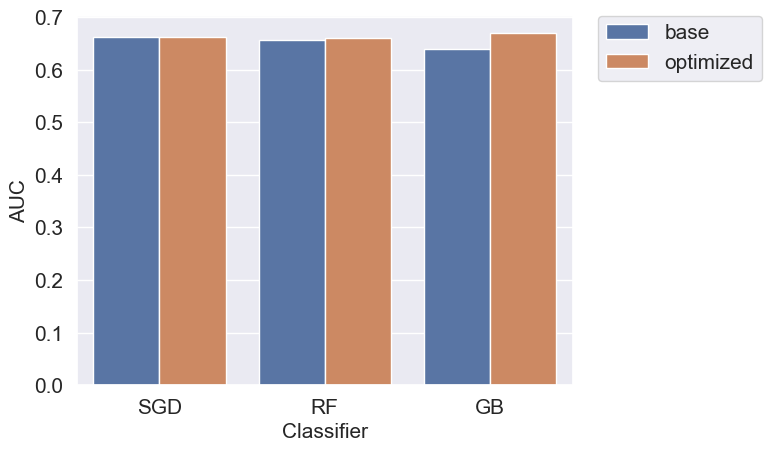

In [102]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

### Model Selection: Best Classifier

Here we will chose the gradient boosting classifier since it has the best AUC on the validation set. 

In [103]:
pickle.dump(gbc_random.best_estimator_, open('best_classifier.pkl', 'wb'),protocol = 4)

### Model Evaluation

Now that we have selected our best model. Let's evaluate the performance of the test set.

In [104]:
X_test = df_test[new_df].values
y_test = df_test['OUTPUT_LABEL'].values

scaler = pickle.load(open('scaler.sav', 'rb'))
X_test_tf = scaler.transform(X_test)

In [106]:
best_model = pickle.load(open('best_classifier.pkl','rb'))

In [107]:
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]

In [108]:
thresh = 0.5

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = print_report(y_valid,y_valid_preds, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = print_report(y_test,y_test_preds, thresh)

Training:
AUC:0.698
accuracy:0.642
recall:0.584
precision:0.660
specificity:0.699
prevalence:0.500
 
Validation:
AUC:0.669
accuracy:0.661
recall:0.574
precision:0.182
specificity:0.672
prevalence:0.113
 
Test:
AUC:0.666
accuracy:0.653
recall:0.576
precision:0.185
specificity:0.664
prevalence:0.117
 


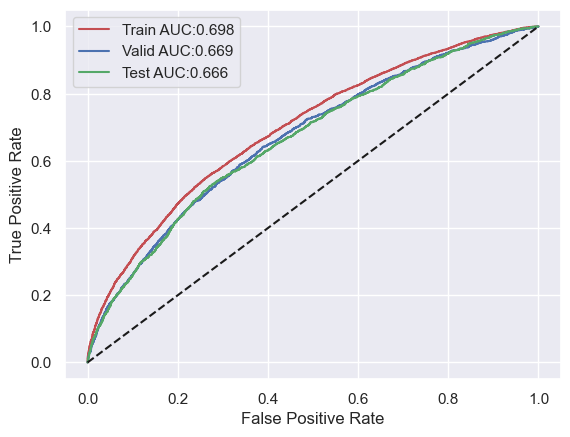

In [109]:
from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()